In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
provider = pd.read_csv('Train-1542865627584.csv')
bene = pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
inpatient = pd.read_csv('Train_Inpatientdata-1542865627584.csv')
outpatient = pd.read_csv('Train_Outpatientdata-1542865627584.csv')

In [3]:
inpatient['patient_type'] = 'inpatient'
outpatient['patient_type'] = 'outpatient'

In [4]:
patients = pd.concat([inpatient,outpatient], axis = 0)

In [5]:
merged_data = patients.merge(bene, how = 'left', on = 'BeneID')

In [6]:
final_patients = merged_data.merge(provider, how = 'left', on = 'Provider')

In [7]:
#making a copy of merged data
patient_record = final_patients.copy()

## Changing into DateTime 

In [8]:
patient_record[['DOB', 'ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']] = \
    patient_record[['DOB', 'ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']].apply(pd.to_datetime, 
                                                                                               format ='%Y-%m-%d')

## Total number of patients and type of patient(inpatient, outpatient, both)

In [9]:
total = patient_record.groupby(['Provider', 'BeneID'])['BeneID'].count().reset_index(name = 'patient_count')
total = total.groupby('Provider')['patient_count'].count().reset_index()
provider2 = provider.merge(total, how = 'left', on = 'Provider')

In [10]:
inpatient_list = patient_record[patient_record['patient_type'] == 'inpatient'].Provider.to_list()
outpatient_list = patient_record[patient_record['patient_type'] == 'outpatient'].Provider.to_list()

In [11]:
common_patient = set(inpatient_list) & set(outpatient_list)

In [12]:
patient_record.loc[patient_record.Provider.isin(common_patient), 'common_patient'] = 'Both'
patient_record.loc[~patient_record.Provider.isin(common_patient), 'common_patient'] = 0

In [13]:
patient_record['patient_type'].mask(patient_record['common_patient'] == 'Both', 'both', inplace = True)

In [14]:
patient_type = patient_record[['Provider', 'patient_type']]

In [15]:
provider2 = provider2.merge(patient_type, how = 'left', on = 'Provider')

In [16]:
provider2.drop_duplicates(subset = ['Provider'],keep = 'first', inplace = True)

In [17]:
provider2.head(5)

,Provider,PotentialFraud,patient_count,patient_type
0,PRV51001,No,24,both
25,PRV51003,Yes,117,both
157,PRV51004,No,138,outpatient
306,PRV51005,Yes,495,outpatient
1471,PRV51007,No,58,both


## Race

In [18]:
race = patient_record.groupby(['Provider', 'BeneID', 'Race'])['Race'].count().reset_index(name = 'race_count')

In [19]:
race.head()

,Provider,BeneID,Race,race_count
0,PRV51001,BENE102690,1,1
1,PRV51001,BENE106078,1,1
2,PRV51001,BENE11727,1,1
3,PRV51001,BENE123416,1,1
4,PRV51001,BENE126477,1,1


In [20]:
race2 = race.groupby(['Provider', 'Race'])['race_count'].count().reset_index(name = 'race_count1')

In [21]:
race2 = race2.pivot(index = 'Provider', columns = 'Race', values = 'race_count1')

In [22]:
race2.columns = ['Race1', 'Race2', 'Race3', 'Race5']

In [23]:
provider2 = provider2.merge(race2, how = 'left', on = 'Provider')

In [24]:
provider2[['Race1', 'Race2', 'Race3', 'Race5']] = provider2[['Race1', 'Race2', 'Race3', 'Race5']].fillna(0)

## Gender

In [26]:
gender = patient_record.groupby(['Provider', 'BeneID','Gender'])['Gender'].count().reset_index(name = 'gender_count')


In [27]:
gender2 = gender.groupby(['Provider', 'Gender'])['gender_count'].count().reset_index(name = 'gender_count1')

In [28]:
gender2 = gender2.pivot(index = 'Provider', columns = 'Gender', values = 'gender_count1')

In [29]:
gender2.columns = ['Male', 'Female']

In [33]:
provider2

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0
...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,24,outpatient,19.0,1.0,0.0,4.0,13.0,11.0
5406,PRV57760,No,9,outpatient,7.0,2.0,0.0,0.0,6.0,3.0
5407,PRV57761,No,67,outpatient,58.0,5.0,1.0,3.0,33.0,34.0
5408,PRV57762,No,1,outpatient,1.0,0.0,0.0,0.0,1.0,0.0


In [31]:
provider2 = provider2.merge(gender2, how = 'left', on = 'Provider')

In [32]:
provider2[['Male', 'Female']] = provider2[['Male', 'Female']].fillna(0)

## Age

In [34]:
patient_record['Age'] = patient_record['ClaimStartDt'].dt.year.astype(int) - patient_record['DOB'].dt.year.astype(int)

In [36]:
age = patient_record.groupby(['Provider'])['Age'].mean().reset_index(name = 'mean_age').round()

In [37]:
age

,Provider,mean_age
0,PRV51001,78.0
1,PRV51003,70.0
2,PRV51004,72.0
3,PRV51005,70.0
4,PRV51007,69.0
...,...,...
5405,PRV57759,73.0
5406,PRV57760,61.0
5407,PRV57761,71.0
5408,PRV57762,67.0


In [38]:
provider2 = provider2.merge(age, how = 'left', on = 'Provider')

In [39]:
provider2.head(2)

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0


## State

In [40]:
state = patient_record.groupby(['Provider', 'State'])['State'].count().reset_index(name = 'state_count')
state = state.groupby('Provider')['state_count'].count().reset_index()

In [41]:
provider2 = provider2.merge(state, how = 'left', on = 'Provider')

In [42]:
provider2.head(2)

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3


## Physician

In [43]:
Att_phy = patient_record.groupby(['Provider', 'AttendingPhysician'])['AttendingPhysician'].count()\
.reset_index(name = 'phy_count')

In [44]:
Att_phy = Att_phy.groupby('Provider')['phy_count'].count().reset_index()

In [45]:
provider2 = provider2.merge(Att_phy, how = 'left', on = 'Provider')

In [46]:
provider2.head(8)

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10
5,PRV51008,No,36,both,28.0,8.0,0.0,0.0,16.0,20.0,75.0,2,10
6,PRV51011,No,53,both,46.0,7.0,0.0,0.0,24.0,29.0,74.0,1,28
7,PRV51012,No,31,outpatient,25.0,6.0,0.0,0.0,8.0,23.0,74.0,3,14


In [47]:
patient_record['noPhysician'] = patient_record[['AttendingPhysician','OperatingPhysician', 'OtherPhysician']]\
                                .isna().all(axis =1)


In [48]:
no_phy = patient_record.groupby(['Provider'])['noPhysician'].sum().reset_index(name = 'no_phy')

In [49]:
provider2 = provider2.merge(no_phy, how = 'left', on = 'Provider')

## Chronic condition

In [50]:
patient_record.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'patient_type', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depressi

In [51]:
patient_record[['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 
                 'ClmProcedureCode_5', 'ClmDiagnosisCode_6','ClmDiagnosisCode_1','ClmDiagnosisCode_2', 
                 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 
                 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8','ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 
                 'DeductibleAmtPaid' ]] = \
patient_record[['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 
                 'ClmProcedureCode_5', 'ClmDiagnosisCode_6','ClmDiagnosisCode_1','ClmDiagnosisCode_2', 
                 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 
                 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8','ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 
                 'DeductibleAmtPaid' ]].fillna(0)

In [52]:
#Change the chronic condition to 1 or 0 encoding from 1, 2

patient_record = patient_record.replace({'ChronicCond_Alzheimer' :2, 'ChronicCond_Heartfailure' : 2, 
                                         'ChronicCond_KidneyDisease' :2,'ChronicCond_Cancer' :2, 
                                         'ChronicCond_ObstrPulmonary' :2 ,'ChronicCond_Depression' :2,
                                        'ChronicCond_Diabetes' :2, 'ChronicCond_IschemicHeart' :2,
                                         'ChronicCond_Osteoporasis' :2, 'ChronicCond_rheumatoidarthritis' :2,
                                        'ChronicCond_stroke' :2}, 0)


In [53]:
patient_record['RenalDiseaseIndicator'].value_counts()

0    448363
Y    109848
Name: RenalDiseaseIndicator, dtype: int64

In [54]:
#change the renal disease indicator in binary encoding(0,1)
patient_record = patient_record.replace({'RenalDiseaseIndicator' :'Y'},1 )
patient_record['RenalDiseaseIndicator'] =patient_record['RenalDiseaseIndicator'].astype(int)

In [55]:
chronic = patient_record.columns[patient_record.columns.str.contains("Chronic")].tolist() 

In [56]:
chronic_data = pd.concat([patient_record[chronic], patient_record['RenalDiseaseIndicator']], axis = 1)

In [57]:
chronic_condition = chronic_data.columns.to_list()

In [58]:
patient_record['chronic_count'] = patient_record[chronic_condition].sum(axis = 1)

In [59]:
chronic_mean = patient_record.groupby(['Provider'])['chronic_count'].mean().round().reset_index(name = 'chronic_mean')

In [60]:
provider2 = provider2.merge(chronic_mean, how = 'left', on = 'Provider')

In [61]:
provider2.head()

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6,2.0,5.0
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10,0.0,4.0


## Claims 2 features(total claim, monthly distribution of claims)

In [62]:
claim = patient_record.groupby(['Provider'])['ClaimID'].count().reset_index(name = 'claim_count')

In [63]:
provider2 = provider2.merge(claim, how = 'left', on = 'Provider')

In [64]:
patient_record['ClaimStartMonth'] = patient_record['ClaimStartDt'].dt.month.astype(int)

In [65]:
month_claim = patient_record.groupby(['Provider', 'ClaimStartMonth'])['ClaimID'].count().\
        reset_index(name = 'claim_month')

In [66]:
month_claim

,Provider,ClaimStartMonth,claim_month
0,PRV51001,1,2
1,PRV51001,2,4
2,PRV51001,3,3
3,PRV51001,4,2
4,PRV51001,5,5
...,...,...,...
49711,PRV57763,8,16
49712,PRV57763,9,18
49713,PRV57763,10,9
49714,PRV57763,11,13


In [67]:
month_claim2 = month_claim.pivot(index = 'Provider', columns = 'ClaimStartMonth', values = 'claim_month')

In [68]:
month_claim2.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [69]:
provider2 = provider2.merge(month_claim2, how = 'left', on = 'Provider')

In [70]:
provider2[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']] = \
    provider2[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].fillna(0)

In [71]:
provider2

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0,25,2.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0,132,13.0,16.0,10.0,10.0,8.0,14.0,11.0,13.0,9.0,11.0,11.0,6.0
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0,149,12.0,19.0,18.0,10.0,8.0,11.0,14.0,10.0,12.0,11.0,8.0,16.0
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6,2.0,5.0,1165,102.0,101.0,113.0,98.0,83.0,103.0,92.0,99.0,107.0,111.0,73.0,83.0
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10,0.0,4.0,72,6.0,5.0,9.0,4.0,9.0,9.0,3.0,6.0,7.0,2.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,24,outpatient,19.0,1.0,0.0,4.0,13.0,11.0,73.0,1,1,0.0,5.0,28,6.0,1.0,2.0,2.0,4.0,3.0,3.0,1.0,2.0,1.0,2.0,1.0
5406,PRV57760,No,9,outpatient,7.0,2.0,0.0,0.0,6.0,3.0,61.0,1,3,0.0,4.0,22,1.0,5.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,0.0,2.0,1.0
5407,PRV57761,No,67,outpatient,58.0,5.0,1.0,3.0,33.0,34.0,71.0,1,2,0.0,5.0,82,5.0,6.0,4.0,5.0,8.0,10.0,5.0,5.0,4.0,14.0,11.0,5.0
5408,PRV57762,No,1,outpatient,1.0,0.0,0.0,0.0,1.0,0.0,67.0,1,1,0.0,5.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Days Admitted

In [72]:
patient_record.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'patient_type', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depressi

In [73]:
patient_record['days_admitted'] = (patient_record['ClaimEndDt'] - patient_record['ClaimStartDt']).dt.days.astype(int) 

In [84]:
patient_record['days_admitted'] = patient_record['days_admitted'] + 1

In [85]:
days_admitted = patient_record.groupby('Provider')['days_admitted'].mean().round().reset_index(name = 'days_admitted')

In [89]:
provider2.drop(['days_admitted'], inplace = True, axis = 1)

In [87]:
provider2 = provider2.merge(days_admitted, how = 'left', on = 'Provider')

In [88]:
provider2

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,days_admitted
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0,25,2.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,4.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0,132,13.0,16.0,10.0,10.0,8.0,14.0,11.0,13.0,9.0,11.0,11.0,6.0,7.0
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0,149,12.0,19.0,18.0,10.0,8.0,11.0,14.0,10.0,12.0,11.0,8.0,16.0,4.0
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6,2.0,5.0,1165,102.0,101.0,113.0,98.0,83.0,103.0,92.0,99.0,107.0,111.0,73.0,83.0,4.0
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10,0.0,4.0,72,6.0,5.0,9.0,4.0,9.0,9.0,3.0,6.0,7.0,2.0,6.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,24,outpatient,19.0,1.0,0.0,4.0,13.0,11.0,73.0,1,1,0.0,5.0,28,6.0,1.0,2.0,2.0,4.0,3.0,3.0,1.0,2.0,1.0,2.0,1.0,5.0
5406,PRV57760,No,9,outpatient,7.0,2.0,0.0,0.0,6.0,3.0,61.0,1,3,0.0,4.0,22,1.0,5.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,0.0,2.0,1.0,3.0
5407,PRV57761,No,67,outpatient,58.0,5.0,1.0,3.0,33.0,34.0,71.0,1,2,0.0,5.0,82,5.0,6.0,4.0,5.0,8.0,10.0,5.0,5.0,4.0,14.0,11.0,5.0,4.0
5408,PRV57762,No,1,outpatient,1.0,0.0,0.0,0.0,1.0,0.0,67.0,1,1,0.0,5.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0


## Financial Features

### InscClaimAmtReimbursed

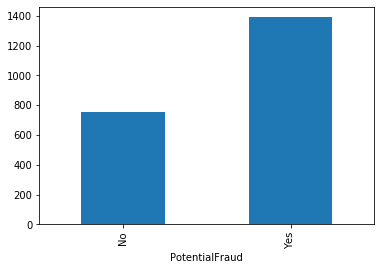

In [100]:
patient_record.groupby('PotentialFraud')['InscClaimAmtReimbursed'].mean().plot.bar()

In [91]:
Reim = patient_record.groupby('Provider')['InscClaimAmtReimbursed'].mean().reset_index(name = 'InscClaimAmtReimbursed')

In [92]:
provider2 = provider2.merge(Reim, how = 'left', on = 'Provider')

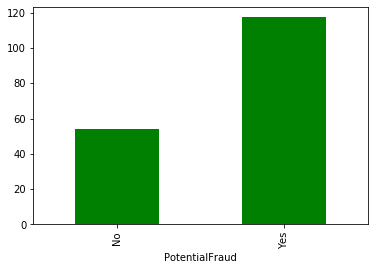

In [101]:
patient_record.groupby('PotentialFraud')['DeductibleAmtPaid'].mean().plot.bar(color = 'green')

In [102]:
deduct = patient_record.groupby('Provider')['DeductibleAmtPaid'].mean().reset_index(name = 'DeductibleAmtPaid')

In [103]:
provider2 = provider2.merge(deduct, how = 'left', on = 'Provider')

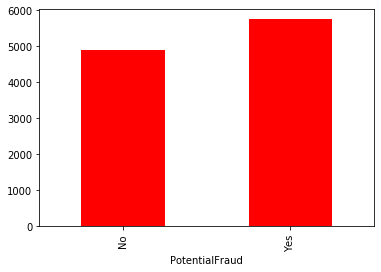

In [104]:
patient_record.groupby('PotentialFraud')['IPAnnualReimbursementAmt'].mean().plot.bar(color = 'red')

In [105]:
IP_reim = patient_record.groupby('Provider')['IPAnnualReimbursementAmt'].mean()\
        .reset_index(name = 'IPAnnualReimbursementAmt')

In [106]:
provider2 = provider2.merge(IP_reim, how = 'left', on = 'Provider')

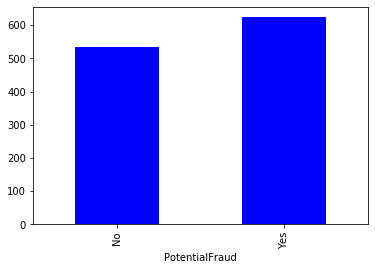

In [107]:
patient_record.groupby('PotentialFraud')['IPAnnualDeductibleAmt'].mean().plot.bar(color = 'blue')

In [108]:
IP_deduct = patient_record.groupby('Provider')['IPAnnualDeductibleAmt'].mean()\
        .reset_index(name = 'IPAnnualDeductibleAmt')

In [109]:
provider2 = provider2.merge(IP_deduct, how = 'left', on = 'Provider')

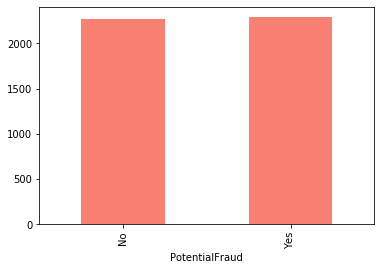

In [110]:
patient_record.groupby('PotentialFraud')['OPAnnualReimbursementAmt'].mean().plot.bar(color = 'salmon')

In [111]:
OP_reim = patient_record.groupby('Provider')['OPAnnualReimbursementAmt'].mean()\
        .reset_index(name = 'OPAnnualReimbursementAmt')

In [112]:
provider2 = provider2.merge(OP_reim, how = 'left', on = 'Provider')

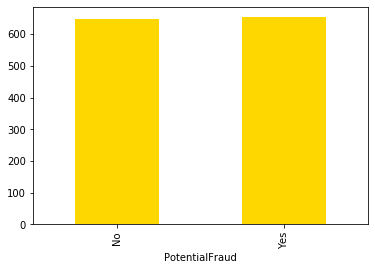

In [113]:
patient_record.groupby('PotentialFraud')['OPAnnualDeductibleAmt'].mean().plot.bar(color = 'gold')

In [114]:
OP_deduct = patient_record.groupby('Provider')['OPAnnualDeductibleAmt'].mean()\
        .reset_index(name = 'OPAnnualDeductibleAmt')

In [115]:
provider2 = provider2.merge(OP_deduct, how = 'left', on = 'Provider')

In [124]:
provider2

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,coverage
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0,25,2.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,4185.600000,213.600000,17606.000000,897.120000,2615.200000,463.920000,0.975656
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0,132,13.0,16.0,10.0,10.0,8.0,14.0,11.0,13.0,9.0,11.0,11.0,6.0,4588.409091,502.166667,7568.181818,931.424242,2678.181818,737.121212,0.912167
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0,149,12.0,19.0,18.0,10.0,8.0,11.0,14.0,10.0,12.0,11.0,8.0,16.0,350.134228,2.080537,4351.879195,434.953020,2194.899329,622.751678,0.978485
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6,2.0,5.0,1165,102.0,101.0,113.0,98.0,83.0,103.0,92.0,99.0,107.0,111.0,73.0,83.0,241.124464,3.175966,3623.991416,379.162232,2109.733906,636.328755,0.980747
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10,0.0,4.0,72,6.0,5.0,9.0,4.0,9.0,9.0,3.0,6.0,7.0,2.0,6.0,6.0,468.194444,45.333333,3050.000000,445.000000,1729.722222,469.722222,0.985303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,24,outpatient,19.0,1.0,0.0,4.0,13.0,11.0,73.0,1,1,0.0,5.0,28,6.0,1.0,2.0,2.0,4.0,3.0,3.0,1.0,2.0,1.0,2.0,1.0,380.000000,4.642857,3962.142857,457.714286,3241.785714,886.785714,0.983401
5406,PRV57760,No,9,outpatient,7.0,2.0,0.0,0.0,6.0,3.0,61.0,1,3,0.0,4.0,22,1.0,5.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,0.0,2.0,1.0,216.818182,0.000000,2785.454545,436.909091,1492.727273,805.454545,1.000000
5407,PRV57761,No,67,outpatient,58.0,5.0,1.0,3.0,33.0,34.0,71.0,1,2,0.0,5.0,82,5.0,6.0,4.0,5.0,8.0,10.0,5.0,5.0,4.0,14.0,11.0,5.0,225.243902,4.512195,7026.585366,586.097561,2928.414634,707.317073,0.935979
5408,PRV57762,No,1,outpatient,1.0,0.0,0.0,0.0,1.0,0.0,67.0,1,1,0.0,5.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1900.000000,0.000000,15000.000000,1068.000000,2540.000000,400.000000,1.000000


In [117]:
patient_record['coverage'] = patient_record['InscClaimAmtReimbursed']\
                    /(patient_record['InscClaimAmtReimbursed'] + patient_record['DeductibleAmtPaid'])

In [125]:
provider2.groupby('PotentialFraud')['coverage'].mean()

PotentialFraud
No     0.962386
Yes    0.935638
Name: coverage, dtype: float64

In [119]:
coverage = patient_record.groupby('Provider')['coverage'].mean().reset_index(name = 'coverage')

In [120]:
provider2 = provider2.merge(coverage, how = 'left', on = 'Provider')

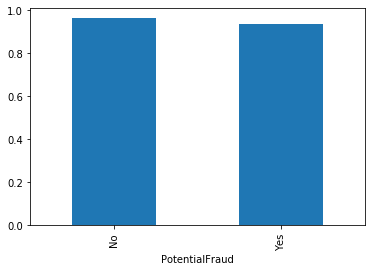

In [129]:
provider2.groupby('PotentialFraud')['coverage'].mean().plot.bar()

In [131]:
provider2

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,coverage
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0,25,2.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,4185.600000,213.600000,17606.000000,897.120000,2615.200000,463.920000,0.975656
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0,132,13.0,16.0,10.0,10.0,8.0,14.0,11.0,13.0,9.0,11.0,11.0,6.0,4588.409091,502.166667,7568.181818,931.424242,2678.181818,737.121212,0.912167
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0,149,12.0,19.0,18.0,10.0,8.0,11.0,14.0,10.0,12.0,11.0,8.0,16.0,350.134228,2.080537,4351.879195,434.953020,2194.899329,622.751678,0.978485
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6,2.0,5.0,1165,102.0,101.0,113.0,98.0,83.0,103.0,92.0,99.0,107.0,111.0,73.0,83.0,241.124464,3.175966,3623.991416,379.162232,2109.733906,636.328755,0.980747
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10,0.0,4.0,72,6.0,5.0,9.0,4.0,9.0,9.0,3.0,6.0,7.0,2.0,6.0,6.0,468.194444,45.333333,3050.000000,445.000000,1729.722222,469.722222,0.985303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,24,outpatient,19.0,1.0,0.0,4.0,13.0,11.0,73.0,1,1,0.0,5.0,28,6.0,1.0,2.0,2.0,4.0,3.0,3.0,1.0,2.0,1.0,2.0,1.0,380.000000,4.642857,3962.142857,457.714286,3241.785714,886.785714,0.983401
5406,PRV57760,No,9,outpatient,7.0,2.0,0.0,0.0,6.0,3.0,61.0,1,3,0.0,4.0,22,1.0,5.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,0.0,2.0,1.0,216.818182,0.000000,2785.454545,436.909091,1492.727273,805.454545,1.000000
5407,PRV57761,No,67,outpatient,58.0,5.0,1.0,3.0,33.0,34.0,71.0,1,2,0.0,5.0,82,5.0,6.0,4.0,5.0,8.0,10.0,5.0,5.0,4.0,14.0,11.0,5.0,225.243902,4.512195,7026.585366,586.097561,2928.414634,707.317073,0.935979
5408,PRV57762,No,1,outpatient,1.0,0.0,0.0,0.0,1.0,0.0,67.0,1,1,0.0,5.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1900.000000,0.000000,15000.000000,1068.000000,2540.000000,400.000000,1.000000


### Total Amount charged

In [351]:
patient_record['totalamount_charged'] = patient_record['InscClaimAmtReimbursed'] +patient_record['DeductibleAmtPaid']

In [352]:
total = patient_record.groupby('Provider')['totalamount_charged'].mean().reset_index(name = 'totalamount_charged')

In [353]:
provider2 = provider2.merge(total, how = 'left', on = 'Provider')

### Revenue(daily_charge)

In [354]:
patient_record['revenue_per_day'] = patient_record['totalamount_charged']/ patient_record['days_admitted']

In [356]:
revenue = patient_record.groupby('Provider')['revenue_per_day'].mean().reset_index(name = 'revenue_day')

In [357]:
provider2 = provider2.merge(revenue, how = 'left', on = 'Provider')

### Annual total amount

In [358]:
patient_record['annual_amount'] = patient_record['IPAnnualReimbursementAmt'] + patient_record['IPAnnualDeductibleAmt']\
                + patient_record['OPAnnualReimbursementAmt'] + patient_record['OPAnnualDeductibleAmt']

In [359]:
annual_amount = patient_record.groupby('Provider')['annual_amount'].mean().reset_index(name = 'annual_amount')

In [360]:
provider2 = provider2.merge(annual_amount, how = 'left', on = 'Provider')

## Diagnosis and procedural codes

In [202]:
patient_record.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'patient_type', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depressi

In [205]:
claimdiag = patient_record.groupby(['Provider', 'ClmAdmitDiagnosisCode'])['ClmAdmitDiagnosisCode'].count()\
            .reset_index(name = 'claimdiag')
claimdiag2 = claimdiag.groupby('Provider')['claimdiag'].count().reset_index()

In [206]:
provider2 = provider2.merge(claimdiag2, how = 'left', on = 'Provider')

In [207]:
diag_grp = patient_record.groupby(['Provider', 'DiagnosisGroupCode'])['DiagnosisGroupCode'].count()\
            .reset_index(name = 'diag_grp')
diag_grp2 = diag_grp.groupby('Provider')['diag_grp'].count().reset_index()

In [208]:
provider2 = provider2.merge(diag_grp2, how = 'left', on = 'Provider')

In [210]:
provider2[['claimdiag', 'diag_grp']] =provider2[['claimdiag', 'diag_grp']].fillna(0)

In [196]:
diagnosis = pd.DataFrame(columns = ['diag_code'])
diagnosis['diag_code'] = pd.concat([patient_record["ClmDiagnosisCode_1"],  patient_record["ClmDiagnosisCode_2"], 
                patient_record["ClmDiagnosisCode_3"], patient_record["ClmDiagnosisCode_4"],
                patient_record["ClmDiagnosisCode_5"], patient_record["ClmDiagnosisCode_6"],
                patient_record["ClmDiagnosisCode_7"],patient_record["ClmDiagnosisCode_8"],
                patient_record["ClmDiagnosisCode_9"],patient_record["ClmDiagnosisCode_10"]], axis=0)

In [200]:
#Most freq used diag codes
diagnosis.diag_code.value_counts().head(11).reset_index()

,index,diag_code
0,0,3901394
1,4019,77056
2,25000,37356
3,2724,35763
4,V5869,24904
5,4011,23773
6,42731,20138
7,V5861,20001
8,2720,18268
9,2449,17600


In [249]:
repeat_prov =pd.DataFrame(columns = ['Provider'])
repeat_prov = pd.DataFrame(pd.concat([patient_record['Provider']]*10))

In [269]:
merged_diag = pd.concat([repeat_prov, diagnosis], axis = 1)

In [275]:
DiagCode = merged_diag.groupby(['Provider', 'diag_code'])['diag_code'].count().reset_index(name = 'diag_count')

In [284]:
diag_codelst = ['4019', '25000', '2724', 'V5869', '4011', '42731', 'V5861', '2720', '2449', '4280']
merged_diag2 = merged_diag[merged_diag['diag_code'].isin(diag_codelst)]

In [290]:
DiagCode = merged_diag2.groupby(['Provider', 'diag_code'])['diag_code'].count().reset_index(name = 'diag_count')

In [301]:
diagnosis_code = DiagCode.pivot(index = 'Provider', columns = 'diag_code', values = 'diag_count')

In [302]:
diagnosis_code.columns = ['diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869', 'diag_4011', 'diag_42731', 
                         'diag_V5861','diag_2720', 'diag_2449', 'diag_4280']

In [303]:
provider2 = provider2.merge(diagnosis_code, how = 'left', on = 'Provider')

In [307]:
provider2[['diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869', 'diag_4011', 'diag_42731', 
                         'diag_V5861','diag_2720', 'diag_2449', 'diag_4280']] = \
            provider2[['diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869', 'diag_4011', 'diag_42731', 
                             'diag_V5861','diag_2720', 'diag_2449', 'diag_4280']].fillna(0)

In [308]:
provider2.head(3)

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,coverage,claimdiag,diag_grp,diag_4019,diag_25000,diag_2724,diag_V5869,diag_4011,diag_42731,diag_V5861,diag_2720,diag_2449,diag_4280
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0,25,2.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,4185.600000,213.600000,17606.000000,897.120000,2615.200000,463.920000,0.975656,11.0,5.0,1.0,1.0,2.0,2.0,0.0,3.0,2.0,0.0,0.0,1.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0,132,13.0,16.0,10.0,10.0,8.0,14.0,11.0,13.0,9.0,11.0,11.0,6.0,4588.409091,502.166667,7568.181818,931.424242,2678.181818,737.121212,0.912167,58.0,58.0,12.0,15.0,7.0,16.0,3.0,25.0,11.0,14.0,6.0,7.0
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0,149,12.0,19.0,18.0,10.0,8.0,11.0,14.0,10.0,12.0,11.0,8.0,16.0,350.134228,2.080537,4351.879195,434.953020,2194.899329,622.751678,0.978485,25.0,0.0,8.0,8.0,6.0,12.0,6.0,22.0,3.0,1.0,4.0,2.0


### Procedure codes

In [309]:
procedure = pd.DataFrame(columns = ['proc_code'])
procedure['proc_code'] = pd.concat([patient_record["ClmProcedureCode_1"],  patient_record["ClmProcedureCode_2"], 
                patient_record["ClmProcedureCode_3"], patient_record["ClmProcedureCode_4"],
                patient_record["ClmProcedureCode_5"], patient_record['ClmProcedureCode_6']], axis=0)

In [310]:
procedure.proc_code.value_counts().head(11).reset_index()

,index,proc_code
0,0.0,2761159
1,4019.0,1959
2,9904.0,1152
3,2724.0,1054
4,8154.0,1022
5,66.0,901
6,3893.0,854
7,3995.0,809
8,4516.0,651
9,3722.0,589


In [312]:
repeat_prov2 =pd.DataFrame(columns = ['Provider'])
repeat_prov2 = pd.DataFrame(pd.concat([patient_record['Provider']]*6))

In [313]:
merged_proc = pd.concat([repeat_prov2, procedure], axis = 1)

In [314]:
ProcCode = merged_proc.groupby(['Provider', 'proc_code'])['proc_code'].count().reset_index(name = 'proc_count')

In [317]:
proc_codelist = ['4019', '9904', '2724', '8154', '66', '3893', '3995', '4516', '3722', '8151']
merged_proc2 = merged_proc[merged_proc['proc_code'].isin(proc_codelist)]

In [318]:
ProcCode = merged_proc2.groupby(['Provider', 'proc_code'])['proc_code'].count().reset_index(name = 'proc_count')

In [320]:
procedure_code = ProcCode.pivot(index = 'Provider', columns = 'proc_code', values = 'proc_count')

In [322]:
procedure_code.columns = ['proc_4019', 'proc_9904', 'proc_2724', 'proc_8154', 'proc_66', 'proc_3893', 'proc_3995',
                          'proc_4516', 'proc_3722', 'proc_8151']

In [323]:
provider2 = provider2.merge(procedure_code, how = 'left', on = 'Provider')

In [324]:
provider2[['proc_4019', 'proc_9904', 'proc_2724', 'proc_8154', 'proc_66', 'proc_3893', 'proc_3995',
                          'proc_4516', 'proc_3722', 'proc_8151']] = \
            provider2[['proc_4019', 'proc_9904', 'proc_2724', 'proc_8154', 'proc_66', 'proc_3893', 'proc_3995',
                          'proc_4516', 'proc_3722', 'proc_8151']].fillna(0)

## Duplicates

In [346]:
#Duplicated_claims
duplicate_claim = patient_record[patient_record.duplicated(subset = [
                        'ClmAdmitDiagnosisCode','DiagnosisGroupCode', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5'], keep = False)]

In [348]:
duplicated_claims = duplicate_claim.groupby(['Provider'])['ClaimID'].count().reset_index(name = 'duplicate_claims')

In [349]:
provider2 = provider2.merge(duplicated_claims, how = 'left', on = 'Provider')

In [350]:
provider2[['duplicate_claims']] = provider2[['duplicate_claims']].fillna(0)

In [326]:
#Duplicated_bene_count
patient_duplicates = patient_record[patient_record.duplicated(subset = ['BeneID','Provider',
                        'ClmAdmitDiagnosisCode','DiagnosisGroupCode', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5'], keep = False)]

In [329]:
patient_duplicates.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,patient_type,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,common_patient,Age,noPhysician,chronic_count,ClaimStartMonth,days_admitted,coverage
34,BENE11093,CLM32146,2009-01-03,2009-01-09,PRV51842,20000,PHY341192,PHY355416,NaN,2009-01-03,4439,1068.0,2009-01-09,255,99662,2639,E8782,920,V854,4280,E9320,04185,412,42732,3950.0,2762.0,0.0,0.0,0.0,NaN,both,1922-05-01,NaN,2,1,1,6,500,12,12,0,1,1,0,1,1,1,1,1,0,0,20180,1068,33210,5858,Yes,Both,87,False,8,1,9,0.949307
35,BENE11093,CLM82202,2009-01-03,2009-01-12,PRV51842,20000,PHY341192,PHY355416,NaN,2009-01-03,4439,1068.0,2009-01-09,255,99662,2639,E8782,920,V854,4280,E9320,04185,412,42732,3950.0,2762.0,0.0,0.0,0.0,NaN,both,1922-05-01,NaN,2,1,1,6,500,12,12,0,1,1,0,1,1,1,1,1,0,0,20180,1068,33210,5858,Yes,Both,87,False,8,1,12,0.949307
3862,BENE24807,CLM31703,2008-12-31,2009-01-09,PRV54111,13000,PHY360669,PHY408812,NaN,2008-12-31,55221,1068.0,2009-01-09,345,56889,1122,40390,5185,42731,9974,4589,27801,25000,0,5369.0,0.0,0.0,0.0,0.0,NaN,both,1938-01-01,NaN,2,1,0,24,610,12,12,0,1,0,0,0,0,1,1,1,1,0,17000,2136,13320,1148,Yes,Both,70,False,5,12,12,0.924083
3864,BENE24807,CLM82212,2008-12-31,2009-01-11,PRV54111,13000,PHY360669,PHY408812,NaN,2008-12-31,55221,1068.0,2009-01-09,345,56889,1122,40390,5185,42731,9974,4589,27801,25000,0,5369.0,0.0,0.0,0.0,0.0,NaN,both,1938-01-01,NaN,2,1,0,24,610,12,12,0,1,0,0,0,0,1,1,1,1,0,17000,2136,13320,1148,Yes,Both,70,False,5,12,14,0.924083
7751,BENE39346,CLM39007,2009-02-18,2009-02-23,PRV54065,19000,PHY337531,PHY341176,NaN,2009-02-18,44421,1068.0,2009-02-23,254,4422,42731,60783,4019,44021,V1582,2724,25040,4439,27801,3712.0,0.0,0.0,0.0,0.0,NaN,both,1940-05-01,NaN,1,1,0,24,200,12,12,0,0,1,1,0,0,1,1,0,1,0,19000,1068,19180,1708,Yes,Both,69,False,5,2,8,0.946781


In [338]:
patient_duplicate_count = patient_duplicates.groupby(['Provider', 'BeneID'])['BeneID'].count().\
                            reset_index(name = 'patient_duplicate_count')

In [339]:
patient_duplicate_count = patient_duplicate_count.groupby('Provider')['patient_duplicate_count'].count().reset_index()

In [342]:
provider2 = provider2.merge(patient_duplicate_count, how = 'left', on = 'Provider')

In [344]:
provider2[['patient_duplicate_count']] = provider2[['patient_duplicate_count']].fillna(0)

In [361]:
provider2.shape

(5410, 62)